%run feature_engineering.ipynb

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.metrics import mean_squared_error


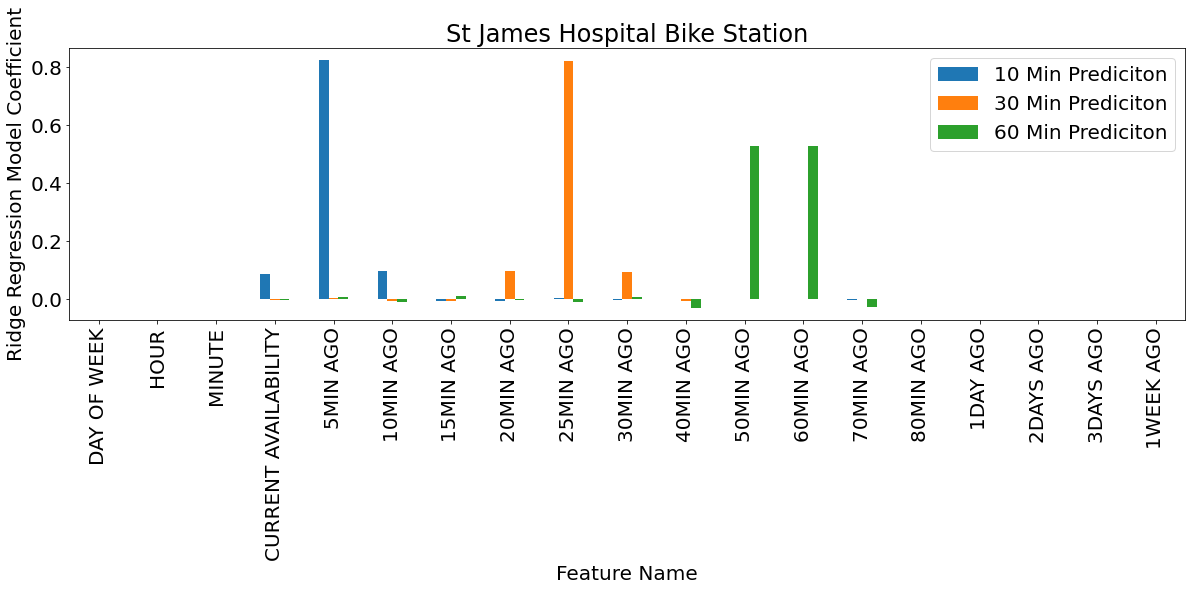

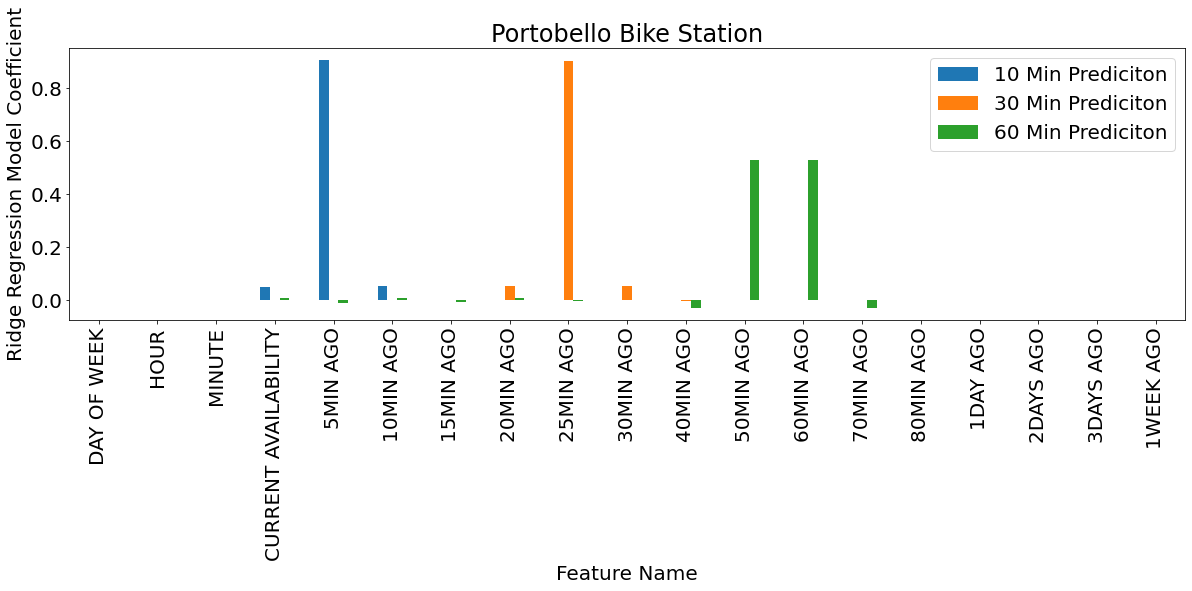

In [14]:
%run feature_engineering.ipynb

Lets save our variables from the previous notebook

In [15]:

df_hospital_map = df_hospital_map
df_portobello_map = df_portobello_map

X_hospital = X_hospital
y_hospital = y_hospital

X_portobello = X_portobello
y_portobello = y_portobello


In [16]:
def test_and_plot_model(model,df :pd.DataFrame, X, y, title:str):
    cv = TimeSeriesSplit(n_splits=5)

    
    mse_scores=[]
    split_count=0
    X = X.to_numpy()
    y = y.to_numpy()
    for train, test in cv.split(X):
        model.fit(X[train], y[train])
        ypred = model.predict(X[test])
        mse_scores.append(mean_squared_error(y[test], ypred))
        split_count=split_count+1
        if split_count == 5:
            plt.rc('font',size=30)
            plt.figure(figsize=(30,20))
            plt.scatter(df.iloc[test].index,y[test],label="actual",marker='o')
            plt.scatter(df.iloc[test].index,ypred,label="predicted")
            plt.xlim(df.iloc[test].index[0],df.iloc[test].index[-1])
            plt.legend()
            plt.xlabel("Time")
            plt.ylabel("Available Bikes")
            

    print("MSE: "+str(np.mean(mse_scores)))
    plt.title(title+" MSE: "+str(np.mean(mse_scores)))

In [17]:
df_hospital_map["60MIN"]

,BIKE STANDS,AVAILABLE BIKES,DAY OF WEEK,HOUR,MINUTE,CURRENT AVAILABILITY,5MIN AGO,10MIN AGO,15MIN AGO,20MIN AGO,...,30MIN AGO,40MIN AGO,50MIN AGO,60MIN AGO,70MIN AGO,80MIN AGO,1DAY AGO,2DAYS AGO,3DAYS AGO,1WEEK AGO
TIME,,,,,,,,,,,,,,,,,,,,,
2020-02-04 00:55:02,40,0.100,0.000000,0.000000,0.964912,0.10,0.10,0.10,0.10,0.10,...,0.100,0.100,0.100,0.100,0.100,0.100,0.275,0.65,0.875,0.525
2020-02-04 01:00:02,40,0.100,0.000000,0.043478,0.000000,0.10,0.10,0.10,0.10,0.10,...,0.100,0.100,0.100,0.100,0.100,0.100,0.275,0.65,0.875,0.525
2020-02-04 01:05:02,40,0.100,0.000000,0.043478,0.087719,0.10,0.10,0.10,0.10,0.10,...,0.100,0.100,0.100,0.100,0.100,0.100,0.275,0.65,0.875,0.525
2020-02-04 01:10:02,40,0.100,0.000000,0.043478,0.175439,0.10,0.10,0.10,0.10,0.10,...,0.100,0.100,0.100,0.100,0.100,0.100,0.275,0.65,0.875,0.525
2020-02-04 01:15:02,40,0.100,0.000000,0.043478,0.263158,0.10,0.10,0.10,0.10,0.10,...,0.100,0.100,0.100,0.100,0.100,0.100,0.275,0.65,0.875,0.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-12 23:35:02,40,0.575,0.333333,1.000000,0.614035,0.55,0.55,0.55,0.55,0.55,...,0.575,0.575,0.575,0.575,0.550,0.550,0.225,0.50,0.450,0.700
2020-03-12 23:40:02,40,0.575,0.333333,1.000000,0.701754,0.55,0.55,0.55,0.55,0.55,...,0.575,0.575,0.575,0.575,0.575,0.550,0.225,0.50,0.450,0.700
2020-03-12 23:45:02,40,0.575,0.333333,1.000000,0.789474,0.55,0.55,0.55,0.55,0.55,...,0.550,0.575,0.575,0.575,0.575,0.550,0.250,0.50,0.450,0.700


MSE: 0.0008245401333684951


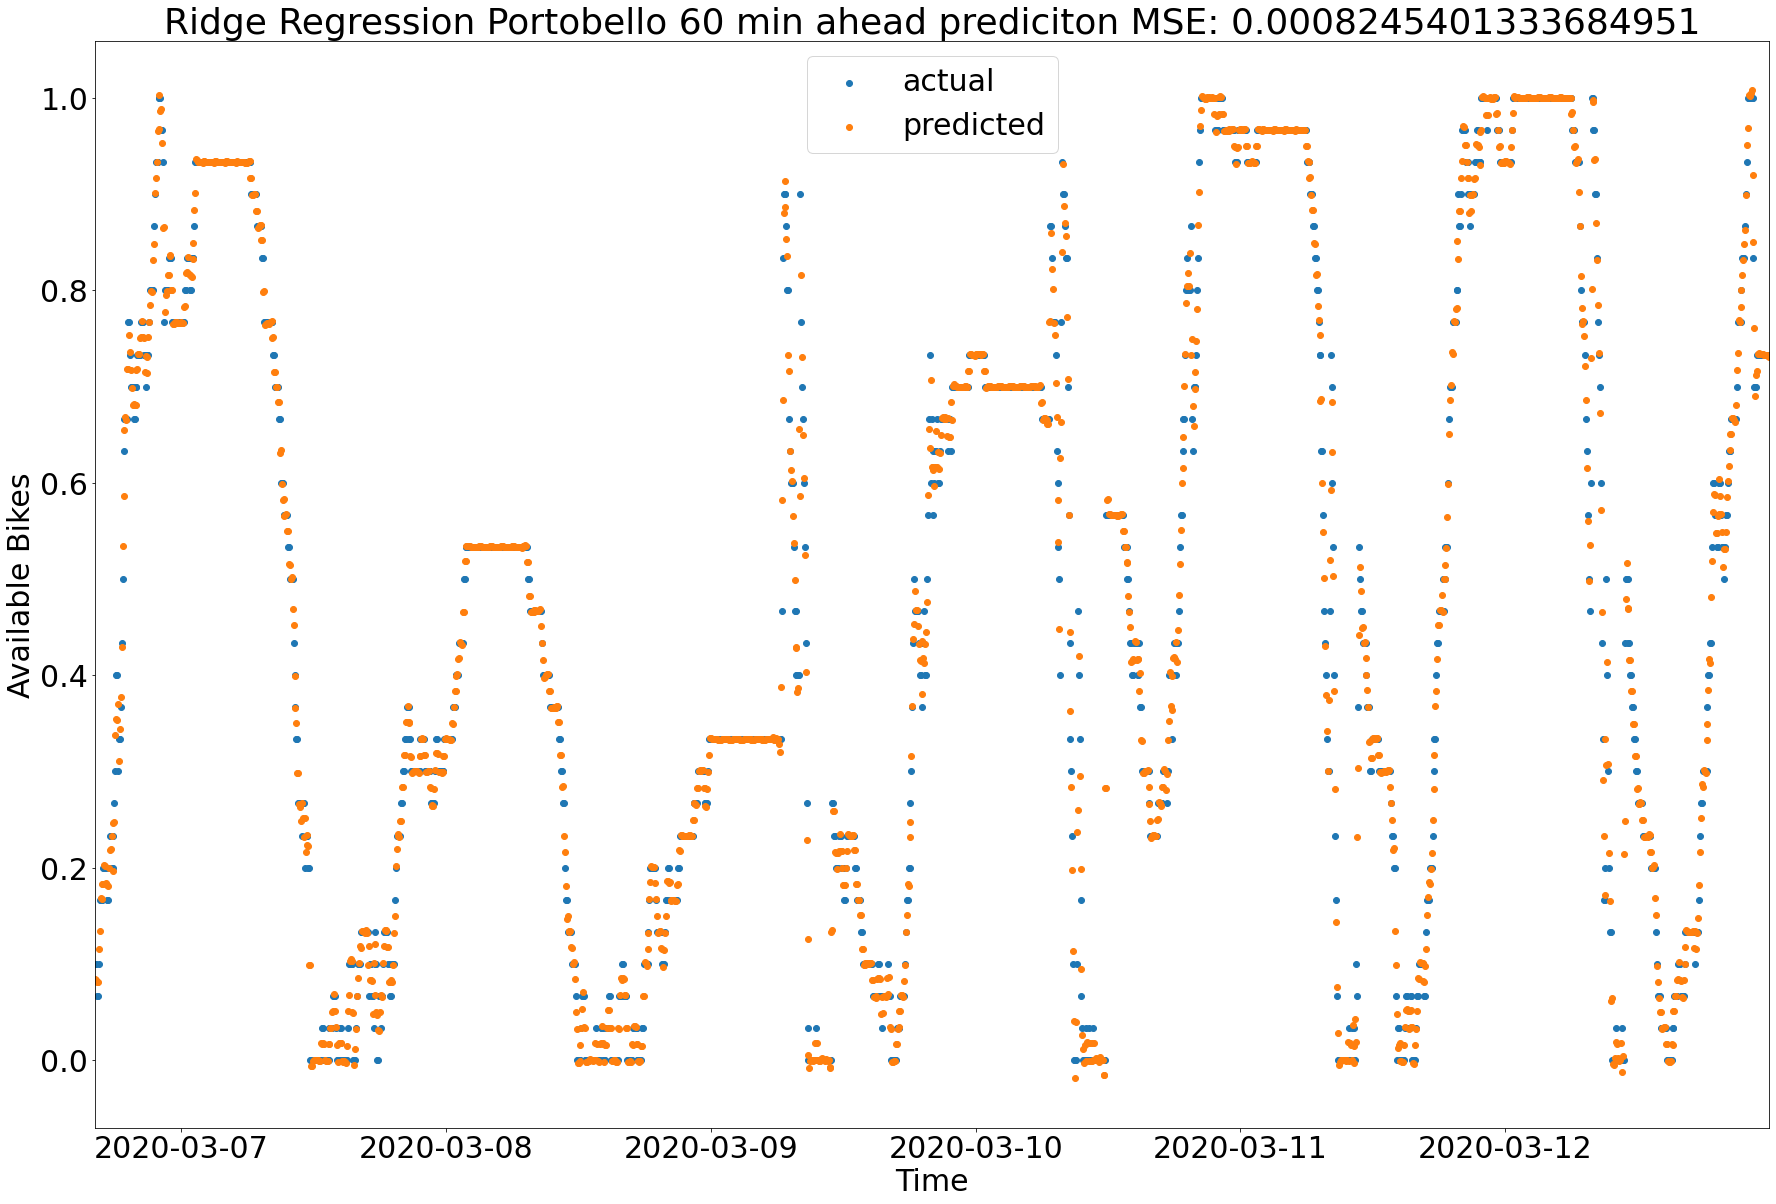

In [18]:

test_and_plot_model(Ridge(),df_portobello_map["60MIN"],X_portobello["60MIN"],y_portobello["60MIN"],"Ridge Regression Portobello 60 min ahead prediciton")
